# info

This script takes raw XCMS file as input.

The tasks are:
- cell number correction.
- quantile normalization across all samples.
- dose-response inference based on patient-specific fold-changes.
    
Then the output should be a list of m/z features for manual annotation.

In [1]:
import pandas, numpy, seaborn

import sklearn, sklearn.decomposition, sklearn.preprocessing
import scipy, scipy.stats

import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 'font.family':'sans-serif', 'xtick.labelsize':20, 'ytick.labelsize':20, 'figure.figsize':(12, 8)})

# 0. user-defined variables

In [2]:
data_file = '/home/adrian/gd15/hi/research/huvec/data/untargetted/ROSA_ACID_NEG_UT_NOMISNORM_AllBatches_untransformed.xlsx'

In [3]:
patients = [1, 2, 3, 4, 5]
time_points = [4, 24]
treatments = [1, 10, 100]

# 1. read data

In [4]:
original_data = pandas.read_excel(data_file)
original_data.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,287.490913,468.605181,189.373225,576.720535,...,465.887121,538.617987,445.230813,507.349690,316.742342,1704.549078,2324.193317,3058.642052,2278.023742,2335.314302
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,180.314261,538.342307,130.499826,603.217924,...,715.677228,713.253520,518.775906,755.134538,123.522480,2331.474888,3382.452083,2496.359276,3421.428464,3531.897024
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,284.725250,346.699905,391.221386,430.336737,...,430.145981,471.505944,371.179769,556.979273,103.571678,1891.004688,1694.637198,1856.663944,1758.452722,1738.477130
3,EC_Rosa_1_695,31,EGM,2,NaN,0,215.383340,632.252573,521.709396,334.036661,...,632.334182,668.358819,546.989703,731.548349,229.357094,1411.265683,1856.889097,2134.864349,2284.850823,2055.847626
4,EC_Rosa_1_711,32,EGM,2,NaN,0,308.400509,461.052002,269.282993,759.247147,...,327.326707,452.810036,324.323485,546.560671,12.509056,1898.663392,2342.170593,2813.164141,2517.026143,2493.479576


In [5]:
info = original_data.iloc[:, :6]
info.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME
0,EC_Rosa_1_659,4,EGM,1,480000.0,0
1,EC_Rosa_1_666,5,EGM,1,480000.0,0
2,EC_Rosa_1_668,3,EGM,1,480000.0,0
3,EC_Rosa_1_695,31,EGM,2,NaN,0
4,EC_Rosa_1_711,32,EGM,2,NaN,0


In [6]:
intensities = original_data.iloc[:, 6:]
intensities.head()

,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,287.490913,468.605181,189.373225,576.720535,321.251154,490.368895,6963.243332,1574.419726,205.341230,224.308740,...,465.887121,538.617987,445.230813,507.349690,316.742342,1704.549078,2324.193317,3058.642052,2278.023742,2335.314302
1,180.314261,538.342307,130.499826,603.217924,474.653477,426.956672,3643.910179,1315.831068,154.358128,170.502985,...,715.677228,713.253520,518.775906,755.134538,123.522480,2331.474888,3382.452083,2496.359276,3421.428464,3531.897024
2,284.725250,346.699905,391.221386,430.336737,513.463286,895.284301,4228.235643,1443.006843,212.677132,391.189120,...,430.145981,471.505944,371.179769,556.979273,103.571678,1891.004688,1694.637198,1856.663944,1758.452722,1738.477130
3,215.383340,632.252573,521.709396,334.036661,463.543369,871.905092,5835.753747,1678.712440,512.057985,1568.892520,...,632.334182,668.358819,546.989703,731.548349,229.357094,1411.265683,1856.889097,2134.864349,2284.850823,2055.847626
4,308.400509,461.052002,269.282993,759.247147,568.430834,580.175396,1893.502277,1910.773244,312.684534,710.027443,...,327.326707,452.810036,324.323485,546.560671,12.509056,1898.663392,2342.170593,2813.164141,2517.026143,2493.479576


In [7]:
peak_names = original_data.columns.to_list()[6:]
print(len(peak_names))
peak_names[:10]

1230


['X59.01097',
 'X61.017890000000001',
 'X67.016220000000004',
 'X74.021450000000002',
 'X77.052040000000005',
 'X77.052049999999994',
 'X78.956580000000002',
 'X78.956770000000006',
 'X79.955420000000004',
 'X80.962869999999995']

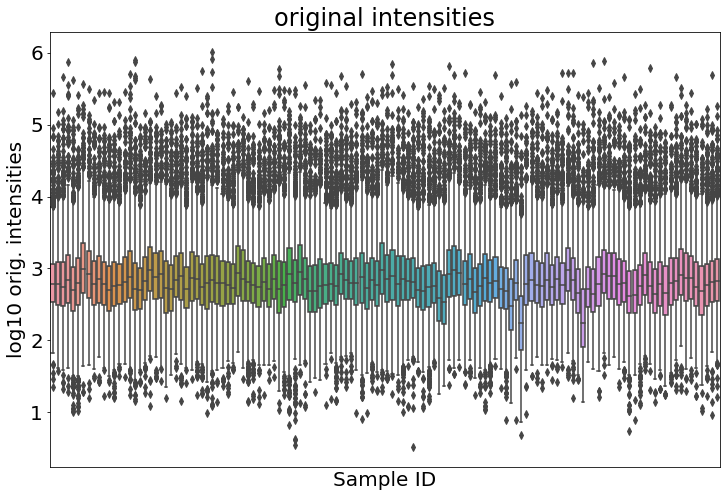

In [8]:
plotting_data = intensities.transpose()

g = seaborn.boxplot(data=numpy.log10(plotting_data))
g.set(xticks=[], ylabel='log10 orig. intensities', xlabel='Sample ID', title='original intensities')
g.tick_params(bottom=False)
matplotlib.pyplot.show()

# 2. normalize data by cell numbers

In [9]:
intensities_by_cell = intensities.div(original_data['Cell  number']/1e6, axis=0)
intensities_by_cell.head(10)

,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,598.939402,976.260794,394.527553,1201.501115,669.273238,1021.601865,14506.756942,3280.041095,427.794229,467.309876,...,970.598168,1122.120807,927.564193,1056.978522,659.879879,3551.143913,4842.069410,6372.170942,4745.882797,4865.238129
1,375.654710,1121.546473,271.874638,1256.704008,988.861411,889.493067,7591.479539,2741.314726,321.579434,355.214552,...,1490.994224,1485.944833,1080.783137,1573.196955,257.338500,4857.239351,7046.775172,5200.748491,7127.975967,7358.118801
2,593.177604,722.291469,815.044553,896.534868,1069.715180,1865.175628,8808.824257,3006.264256,443.077358,814.977334,...,896.137460,982.304050,773.291185,1160.373486,215.774329,3939.593101,3530.494163,3868.049883,3663.443171,3621.827354
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,621.152501,1825.424702,467.294062,2333.133711,1907.808060,2790.453418,23646.966493,8010.429693,660.939824,654.341910,...,2698.087973,2887.812940,2308.506988,2334.598693,2034.044873,9038.588512,11058.163249,12333.298055,12270.745784,10790.108692


In [10]:
normalized_met_by_cell = pandas.concat([info, intensities_by_cell.reindex(info.index)], axis=1)
normalized_met_by_cell.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,598.939402,976.260794,394.527553,1201.501115,...,970.598168,1122.120807,927.564193,1056.978522,659.879879,3551.143913,4842.069410,6372.170942,4745.882797,4865.238129
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,375.654710,1121.546473,271.874638,1256.704008,...,1490.994224,1485.944833,1080.783137,1573.196955,257.338500,4857.239351,7046.775172,5200.748491,7127.975967,7358.118801
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,593.177604,722.291469,815.044553,896.534868,...,896.137460,982.304050,773.291185,1160.373486,215.774329,3939.593101,3530.494163,3868.049883,3663.443171,3621.827354
3,EC_Rosa_1_695,31,EGM,2,NaN,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EC_Rosa_1_711,32,EGM,2,NaN,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. remove conditions without cell numbers

In [11]:
# remove conditions for which cell numbers are not available
print('conditions before filtering {}'.format(normalized_met_by_cell.shape[0]))
finite_normalized_met_by_cell = normalized_met_by_cell[numpy.isfinite(normalized_met_by_cell['Cell  number']) == True]
print('conditions after filtering {}'.format(finite_normalized_met_by_cell.shape[0]))

conditions before filtering 130
conditions after filtering 121


In [12]:
finite_normalized_met_by_cell.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,598.939402,976.260794,394.527553,1201.501115,...,970.598168,1122.120807,927.564193,1056.978522,659.879879,3551.143913,4842.069410,6372.170942,4745.882797,4865.238129
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,375.654710,1121.546473,271.874638,1256.704008,...,1490.994224,1485.944833,1080.783137,1573.196955,257.338500,4857.239351,7046.775172,5200.748491,7127.975967,7358.118801
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,593.177604,722.291469,815.044553,896.534868,...,896.137460,982.304050,773.291185,1160.373486,215.774329,3939.593101,3530.494163,3868.049883,3663.443171,3621.827354
9,EC_Rosa_1_787,85,EGM,4,270000.0,0,621.152501,1825.424702,467.294062,2333.133711,...,2698.087973,2887.812940,2308.506988,2334.598693,2034.044873,9038.588512,11058.163249,12333.298055,12270.745784,10790.108692
10,EC_Rosa_1_805,84,EGM,4,270000.0,0,761.738204,1880.681355,346.274473,2111.788781,...,1861.632957,2131.258746,1706.691679,2467.284050,1637.665077,8454.690040,10424.083896,11610.791792,10437.888669,9955.916753


# 4. bring it all to log10

In [13]:
info = finite_normalized_met_by_cell.iloc[:, :6]
data = finite_normalized_met_by_cell.iloc[:, 6:]
transformed = data.apply(numpy.log10)
log10_finite_normalize_met_by_cell = pandas.concat([info, transformed.reindex(info.index)], axis=1)
log10_finite_normalize_met_by_cell.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,2.777383,2.989566,2.596077,3.079724,...,2.987039,3.050040,2.967344,3.024066,2.819465,3.550368,3.685031,3.804287,3.676317,3.687104
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,2.574789,3.049817,2.434369,3.099233,...,3.173476,3.172003,3.033739,3.196783,2.410505,3.686390,3.847990,3.716066,3.852966,3.866767
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,2.773185,2.858712,2.911181,2.952567,...,2.952375,2.992246,2.888343,3.064598,2.334000,3.595451,3.547835,3.587492,3.563889,3.558928
9,EC_Rosa_1_787,85,EGM,4,270000.0,0,2.793198,3.261364,2.669590,3.367940,...,3.431056,3.460569,3.363331,3.368212,3.308361,3.956101,4.043683,4.091079,4.088871,4.033026
10,EC_Rosa_1_805,84,EGM,4,270000.0,0,2.881806,3.274315,2.539420,3.324650,...,3.269894,3.328636,3.232155,3.392219,3.214225,3.927098,4.018038,4.064862,4.018613,3.998081


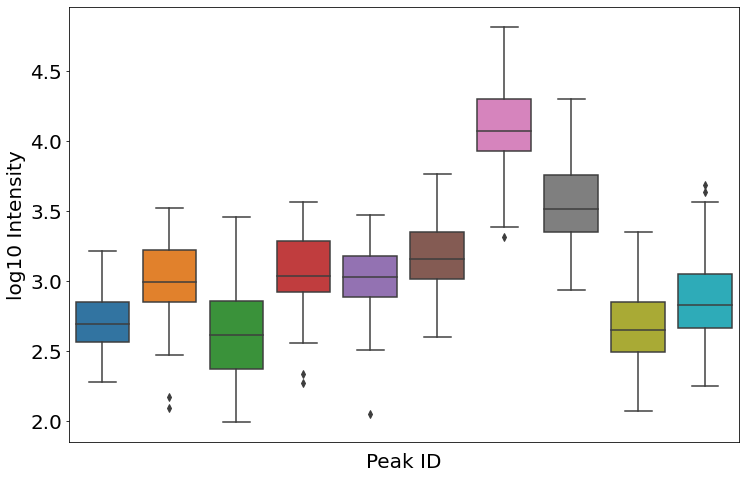

In [14]:
g = seaborn.boxplot(data=log10_finite_normalize_met_by_cell[peak_names[:10]], palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(ylabel='log10 Intensity', xlabel='Peak ID')
matplotlib.pyplot.show()

# 5. Perform quantile normalization

In [15]:
log10_finite_normalize_met_by_cell.head()

,Unnamed: 0,Number,Treatment,Batch,Cell number,TIME,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,4,EGM,1,480000.0,0,2.777383,2.989566,2.596077,3.079724,...,2.987039,3.050040,2.967344,3.024066,2.819465,3.550368,3.685031,3.804287,3.676317,3.687104
1,EC_Rosa_1_666,5,EGM,1,480000.0,0,2.574789,3.049817,2.434369,3.099233,...,3.173476,3.172003,3.033739,3.196783,2.410505,3.686390,3.847990,3.716066,3.852966,3.866767
2,EC_Rosa_1_668,3,EGM,1,480000.0,0,2.773185,2.858712,2.911181,2.952567,...,2.952375,2.992246,2.888343,3.064598,2.334000,3.595451,3.547835,3.587492,3.563889,3.558928
9,EC_Rosa_1_787,85,EGM,4,270000.0,0,2.793198,3.261364,2.669590,3.367940,...,3.431056,3.460569,3.363331,3.368212,3.308361,3.956101,4.043683,4.091079,4.088871,4.033026
10,EC_Rosa_1_805,84,EGM,4,270000.0,0,2.881806,3.274315,2.539420,3.324650,...,3.269894,3.328636,3.232155,3.392219,3.214225,3.927098,4.018038,4.064862,4.018613,3.998081


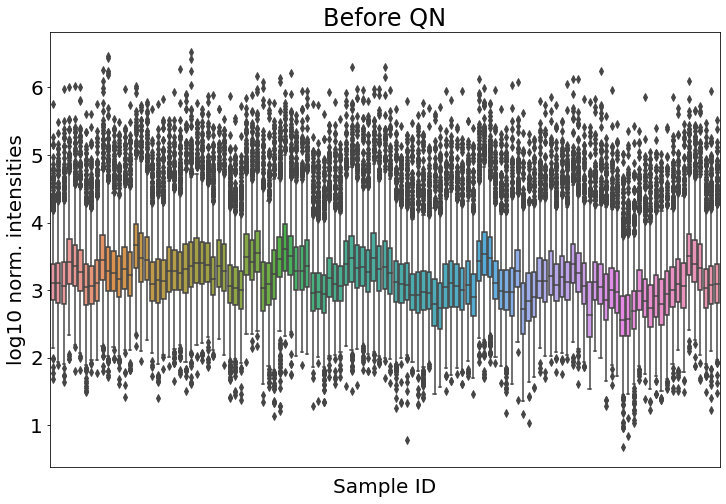

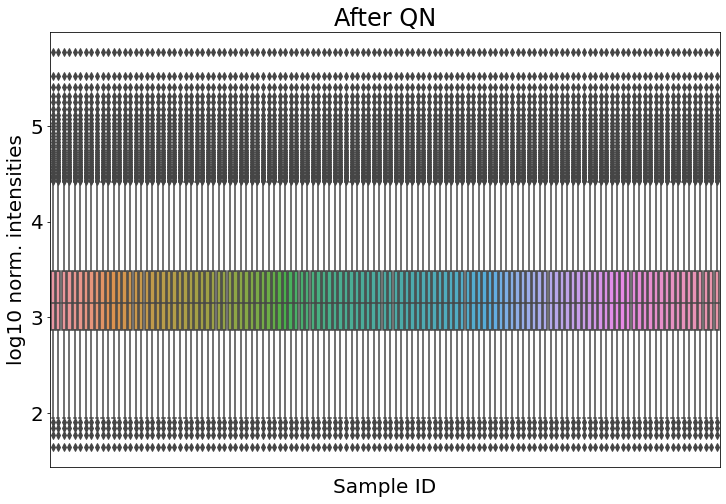

,Sample ID,Treatment,Time,Patient,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,EC_Rosa_1_659,EGM,0,1,2.794334,3.019640,2.627142,3.123284,2.840778,3.044494,...,3.014906,3.091518,2.990505,3.060599,2.835696,3.628641,3.750368,3.891556,3.745615,3.755109
1,EC_Rosa_1_666,EGM,0,1,2.607654,3.104925,2.412584,3.150455,3.051611,3.014100,...,3.233955,3.229593,3.083298,3.252518,2.398358,3.791086,3.932381,3.828591,3.944024,3.952900
2,EC_Rosa_1_668,EGM,0,1,2.837759,2.920775,2.981377,3.026136,3.121434,3.336177,...,3.025199,3.090544,2.948674,3.153500,2.334037,3.675726,3.622862,3.668984,3.644870,3.634795
9,EC_Rosa_1_787,EGM,0,4,2.534132,3.014100,2.353734,3.096735,3.034113,3.186189,...,3.167661,3.202538,3.094173,3.097649,3.057770,3.725911,3.799645,3.850255,3.847260,3.779479
10,EC_Rosa_1_805,EGM,0,4,2.642333,3.061422,2.228784,3.109595,3.047184,3.118578,...,3.055130,3.114162,3.026833,3.195821,3.005070,3.757501,3.834827,3.884510,3.837620,3.813846


In [16]:
###
### plot intensities before QN
###
tdf = log10_finite_normalize_met_by_cell.transpose()
tdf.drop(['Unnamed: 0', 'Number', 'Treatment', 'Batch', 'Cell  number', 'TIME'], axis=0, inplace=True)
tdf.head()

g = seaborn.boxplot(data=tdf)
g.set(xticklabels=[], ylabel='log10 norm. intensities', xlabel='Sample ID', title='Before QN')
g.tick_params(bottom=False)
matplotlib.pyplot.show()

###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(tdf.values, axis=0), index=tdf.index, columns=tdf.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = tdf.rank(method="min").stack().astype(int).map(df_mean).unstack()

# plot intensities after QN
g = seaborn.boxplot(data=df_qn)
g.set(xticklabels=[], ylabel='log10 norm. intensities', xlabel='Sample ID', title='After QN')
g.tick_params(bottom=False)
matplotlib.pyplot.show()

###
### re-join
###
qn_peaks = df_qn.transpose()
qn_peaks.insert(0, 'Patient', log10_finite_normalize_met_by_cell['Batch'])
qn_peaks.insert(0, 'Time', log10_finite_normalize_met_by_cell['TIME']) 
qn_peaks.insert(0, 'Treatment', log10_finite_normalize_met_by_cell['Treatment']) 
qn_peaks.insert(0, 'Sample ID', log10_finite_normalize_met_by_cell['Unnamed: 0'])
qn_peaks.head()

# 6. work with fold-change values

## 6.1. compute fold-change values

In [17]:
fold_change = {}

for peak_mz_name in peak_names:
    
    fold_change['Patient'] = []
    fold_change['Time point'] = []
    fold_change['Treatment'] = []
    fold_change[peak_mz_name] = []
    
    for patient in patients:
        for time_point in time_points:
            for treatment in treatments:
                
                perturbation = qn_peaks[(qn_peaks['Patient'] == patient) & (qn_peaks['Time'] == time_point) & (qn_peaks['Treatment'] == treatment)][peak_mz_name].values
                reference = qn_peaks[(qn_peaks['Patient'] == patient) & (qn_peaks['Time'] == time_point) & (qn_peaks['Treatment'] == 'EGM')][peak_mz_name].values
                
                if numpy.min([len(perturbation), len(reference)]) > 0:
                    
                    num = numpy.log2(10**(numpy.median(perturbation)))
                    den = numpy.log2(10**(numpy.median(reference)))
                    log2FC = num - den
                    
                    fold_change['Patient'].append(patient)
                    fold_change['Time point'].append(time_point)
                    fold_change['Treatment'].append(treatment)
                    fold_change[peak_mz_name].append(log2FC)

In [18]:
fcdf = pandas.DataFrame.from_dict(fold_change)
print(fcdf.shape)
fcdf.head()

(29, 1233)


,Patient,Time point,Treatment,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,1,4,1,0.412074,0.390341,0.087868,-0.003004,0.230350,0.614370,0.173333,...,0.695940,0.422027,0.774416,-0.204977,-1.019337,-0.479833,-0.372593,-0.128202,0.007955,-0.217148
1,1,4,10,0.275676,0.574837,-0.544344,0.283399,0.269589,0.133224,-0.227871,...,1.152540,0.972842,1.270624,0.399085,-2.181333,0.124873,0.154315,0.201675,-0.324745,0.094076
2,1,4,100,0.391458,0.581103,-0.900453,0.335622,0.511662,0.386358,0.319259,...,0.843791,0.718266,0.777477,0.076763,-1.019337,0.030189,0.015750,0.171683,0.187294,-0.038332
3,1,24,1,0.049243,-0.091380,-0.324318,0.105107,0.338171,0.030809,-0.312650,...,-0.432473,-0.449482,-0.244411,-0.070526,-0.999014,-0.374671,-0.220599,-0.254563,-0.115610,0.822616
4,1,24,10,-0.094258,-0.212238,-1.228926,0.048166,0.356508,0.177220,-0.248067,...,-0.955397,-0.700851,-0.739905,-0.397304,-1.358433,0.139711,-0.044990,-0.073655,0.069363,1.043362


## 6.2 visualize samples

In [19]:
pca_input = fcdf.iloc[:, 3:]
pca_input.head()

,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,X78.956770000000006,X79.955420000000004,X80.962869999999995,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,0.412074,0.390341,0.087868,-0.003004,0.230350,0.614370,0.173333,-0.352884,0.486829,0.273817,...,0.695940,0.422027,0.774416,-0.204977,-1.019337,-0.479833,-0.372593,-0.128202,0.007955,-0.217148
1,0.275676,0.574837,-0.544344,0.283399,0.269589,0.133224,-0.227871,-0.495382,0.098994,-0.129307,...,1.152540,0.972842,1.270624,0.399085,-2.181333,0.124873,0.154315,0.201675,-0.324745,0.094076
2,0.391458,0.581103,-0.900453,0.335622,0.511662,0.386358,0.319259,0.129904,0.591680,0.283503,...,0.843791,0.718266,0.777477,0.076763,-1.019337,0.030189,0.015750,0.171683,0.187294,-0.038332
3,0.049243,-0.091380,-0.324318,0.105107,0.338171,0.030809,-0.312650,-0.775139,0.190576,0.576082,...,-0.432473,-0.449482,-0.244411,-0.070526,-0.999014,-0.374671,-0.220599,-0.254563,-0.115610,0.822616
4,-0.094258,-0.212238,-1.228926,0.048166,0.356508,0.177220,-0.248067,-0.327275,0.080765,0.225636,...,-0.955397,-0.700851,-0.739905,-0.397304,-1.358433,0.139711,-0.044990,-0.073655,0.069363,1.043362


In [20]:
pca = sklearn.decomposition.PCA(n_components=2)
x = sklearn.preprocessing.StandardScaler().fit_transform(pca_input)
principalComponents = pca.fit_transform(x)

print(principalComponents.shape)
print(pca.explained_variance_ratio_)

(29, 2)
[0.20411903 0.1325903 ]


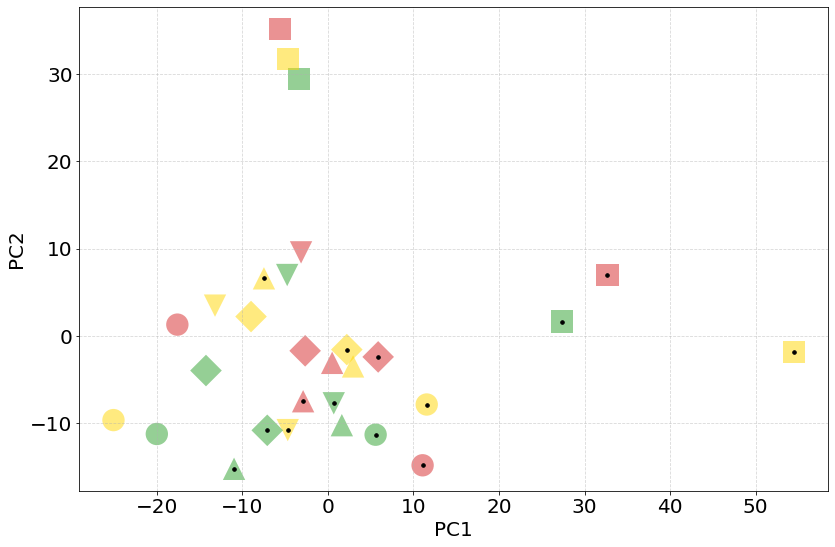

In [21]:
for i in range(len(x)):
    
    # marker based on patient
    patient = fcdf.iloc[i, 0]
    if patient == 1:
        the_marker = 'o'
    elif patient == 2:
        the_marker = 's'
    elif patient == 3:
        the_marker = '^'
    elif patient == 4:
        the_marker = 'v'
    elif patient == 5:
        the_marker = 'D'
    else:
        print('error')
    
    # color based on treatment
    treatment = fcdf.iloc[i, 2]
    if treatment == 1:
        the_color = 'tab:green'
    elif treatment == 10:
        the_color = 'gold'
    elif treatment == 100:
        the_color = 'tab:red'
    else:
        print('error')
    
    matplotlib.pyplot.scatter(principalComponents[i, 0], principalComponents[i, 1], c=the_color, s=500, alpha=0.5, edgecolors='none', marker=the_marker)
    
    if fcdf.iloc[i, 1] == 24:
        matplotlib.pyplot.scatter(principalComponents[i, 0], principalComponents[i, 1], c='black', s=50, edgecolors='black', marker='.')
        
matplotlib.pyplot.xlabel('PC1')
matplotlib.pyplot.ylabel('PC2')
matplotlib.pyplot.grid(alpha=0.5, ls='--')
matplotlib.pyplot.tight_layout()

# 7. spot-check on adrenaline sulfate

In [22]:
# user-defined variables
target = 'epinephrine sulfate'
peak = 'X262.03859999999997'
condition_colors = ['tab:green', 'gold', 'tab:red', 'tab:green', 'gold', 'tab:red']
condition_labels = ['0.5 4h', '5 4h', '50 4h', '0.5 24h', '5 24h', '50 24h']

In [23]:
fcdf.head()

,Patient,Time point,Treatment,X59.01097,X61.017890000000001,X67.016220000000004,X74.021450000000002,X77.052040000000005,X77.052049999999994,X78.956580000000002,...,X970.31845999999996,X970.33735000000001,X972.28162999999995,X986.81443999999999,X996.20851000000005,X996.78913999999997,X996.80704000000003,X996.82538,X996.84303,X996.86003000000005
0,1,4,1,0.412074,0.390341,0.087868,-0.003004,0.230350,0.614370,0.173333,...,0.695940,0.422027,0.774416,-0.204977,-1.019337,-0.479833,-0.372593,-0.128202,0.007955,-0.217148
1,1,4,10,0.275676,0.574837,-0.544344,0.283399,0.269589,0.133224,-0.227871,...,1.152540,0.972842,1.270624,0.399085,-2.181333,0.124873,0.154315,0.201675,-0.324745,0.094076
2,1,4,100,0.391458,0.581103,-0.900453,0.335622,0.511662,0.386358,0.319259,...,0.843791,0.718266,0.777477,0.076763,-1.019337,0.030189,0.015750,0.171683,0.187294,-0.038332
3,1,24,1,0.049243,-0.091380,-0.324318,0.105107,0.338171,0.030809,-0.312650,...,-0.432473,-0.449482,-0.244411,-0.070526,-0.999014,-0.374671,-0.220599,-0.254563,-0.115610,0.822616
4,1,24,10,-0.094258,-0.212238,-1.228926,0.048166,0.356508,0.177220,-0.248067,...,-0.955397,-0.700851,-0.739905,-0.397304,-1.358433,0.139711,-0.044990,-0.073655,0.069363,1.043362


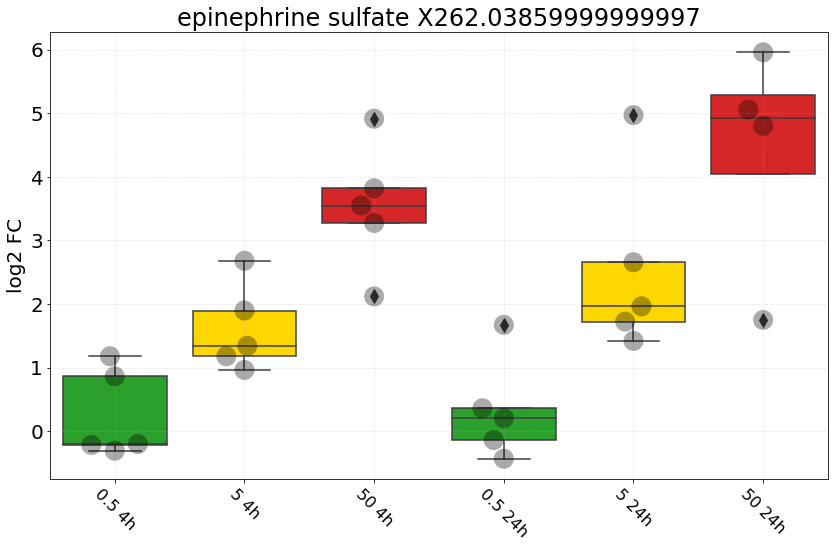

In [24]:
plotting_values = []
for time_point in time_points:
    for treatment in treatments:
        box = fcdf[(fcdf['Time point'] == time_point) & (fcdf['Treatment'] == treatment)]['X262.03859999999997'].values
        plotting_values.append(box)
        
g = seaborn.boxplot(data=plotting_values, fliersize=10)
h = seaborn.swarmplot(data=plotting_values, color='black', alpha=1/3, s=20)
g.set(ylabel='log2 FC', title='{} {}'.format(target, peak))
for i in range(len(g.artists)):
    g.artists[i].set_facecolor(condition_colors[i])
matplotlib.pyplot.xticks(list(range(len(condition_colors))), condition_labels, fontsize=16, rotation=-45)
matplotlib.pyplot.grid(ls=':', alpha=0.5)
matplotlib.pyplot.tight_layout()

# 8. dose-responders analysis

In [25]:
# user-defined variables
delta_threshold = 2 * numpy.log2(1.2)
p_value_threshold = 0.05

In [26]:
correlations_df = pandas.DataFrame(columns=['peak name', 'log2FC', 'P value', 'r value'])
heatmap_data = {}

for peak_name in peak_names:
    heatmap_data[peak_name] = []
    for time_point in time_points:
        
        x = []; y = []; plotting_values = []
        for treatment in treatments:
            box = fcdf[(fcdf['Time point'] == time_point) & (fcdf['Treatment'] == treatment)][peak_name].to_list()
            plotting_values.append(box)
            
            for element in box:
                x.append(numpy.log10(treatment) + 1)
                y.append(element)
                
            # adding data for heatmap plotting
            average_value = numpy.mean(box)
            heatmap_data[peak_name].append(average_value)
            
        # linear regression
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
        ypred = slope*numpy.array(x) + intercept
        delta = numpy.abs(numpy.max(ypred) - numpy.min(ypred))
        
        if r_value > 0:
            log2FC = delta
        else:
            log2FC = -delta
            
        # store tests
        new_row = {'time':time_point, 'peak name':peak_name, 'log2FC':log2FC, 'P value':p_value, 'r value':r_value}
        correlations_df = correlations_df.append(new_row, ignore_index=True)
        
#         # filter just for printing, the appropriate log2FC will be taken empirically
#         if (p_value < p_value_threshold) and numpy.abs(log2FC) > delta_threshold:
#             print(peak_name, time_point, log2FC, r_value, p_value)
            
#             g = seaborn.boxplot(data=plotting_values, fliersize=10)
#             h = seaborn.swarmplot(data=plotting_values, color='black', alpha=1/3, s=20)
#             g.set(ylabel='log2 FC', title='T{} | {}'.format(time_point, peak_name))
#             for i in range(len(g.artists)):
#                 g.artists[i].set_facecolor(condition_colors[i])
#             matplotlib.pyplot.plot(numpy.array(x)-1, ypred, '-', lw=2, color='black')
#             matplotlib.pyplot.xticks([0, 1, 2], ['0.5', '5', '50'], fontsize=16, rotation=-45)
#             matplotlib.pyplot.grid(ls=':', alpha=0.5)
#             matplotlib.pyplot.tight_layout()
#             matplotlib.pyplot.show()
#             matplotlib.pyplot.clf()

In [27]:
selected = correlations_df[(numpy.abs(correlations_df['log2FC']) > delta_threshold) & (correlations_df['P value'] < 0.05)]
print(selected.shape)
selected

(24, 5)


,peak name,log2FC,P value,r value,time
212,X132.02816000000001,-0.940276,0.008202,-0.653786,4.0
231,X134.89306999999999,1.119763,0.044398,0.543846,24.0
269,X146.08017000000001,-0.598634,0.043242,-0.546337,24.0
371,X175.02331000000001,2.179046,0.034321,0.567408,24.0
397,X186.04378_2,-0.814526,0.015824,-0.629628,24.0
573,X226.08796000000001,-0.563439,0.040536,-0.552361,24.0
584,X233.15271000000001,0.691099,0.003408,0.703815,4.0
702,X262.03859999999997,3.273893,0.000020,0.874934,4.0
703,X262.03859999999997,4.075314,0.000604,0.799244,24.0
786,X276.05410000000001,3.613579,0.000030,0.866318,4.0


# 9. generate table for annotation (RT)

In [28]:
rtfile = '/home/adrian/gd15/hi/research/huvec/data/untargetted/annotation/AllBatches_ACID_NEG_ROSA_XCMS.xlsx'
rtinfo = pandas.read_excel(rtfile)
rtinfo.head()

,peak #NOMIS,peak #,mz,mzmin,mzmax,rt,Minutes,rtmin,rtmax,npeaks,...,EC_Rosa_1_846,EC_Rosa_1_847,EC_Rosa_1_848,EC_Rosa_1_849,EC_Rosa_1_850,EC_Rosa_1_851,EC_Rosa_1_852,isotopes,adduct,pcgroup
0,6,6,77.052052,77.050964,77.053342,73.8255,1.230425,72.814,75.227,92,...,1331.746895,1227.194092,1131.619992,1089.361258,1277.997572,955.214377,1354.787960,NaN,NaN,1
1,9,9,79.955424,79.954022,79.956540,74.3950,1.239917,72.896,74.845,15,...,112.537405,113.867823,137.576262,294.547170,135.854693,137.813230,133.426388,NaN,NaN,1
2,36,37,96.957985,96.953473,96.963500,74.3630,1.239383,72.252,77.770,75,...,375.836091,572.028820,251.999940,757.180922,226.234282,695.193460,482.003677,NaN,[M-H-C2H4]- 125.997,1
3,40,41,102.025084,102.023229,102.027498,74.0630,1.234383,73.271,75.227,34,...,310.939722,278.470358,250.039086,377.213085,363.034376,261.422147,228.808784,NaN,[M+Cl]- 67.051,1
4,57,58,110.973640,110.969712,110.977921,74.3630,1.239383,73.187,75.561,128,...,670.571843,458.353613,331.287874,1604.022880,655.803901,437.922388,580.930993,NaN,[M-H-CH2]- 125.997,1


In [29]:
for element in selected['peak name']:
    mz = float(element[1:])
    
    for measured, rt, rtm in zip(rtinfo['mz'], rtinfo['rt'], rtinfo['Minutes']):
        diff = numpy.abs(measured - mz)
        if diff < 1e-5:
            print('{},{},{},{},{}'.format(element, measured, diff, rt, rtm))

X132.02816000000001,132.028159657141,3.428590105158946e-07,280.54,4.675666666666667
X134.89306999999999,134.893066476869,3.5231309993832838e-06,77.674,1.2945666666666669
X146.08017000000001,146.080167893127,2.1068730120532564e-06,151.784,2.529733333333333
X175.02331000000001,175.023313824849,3.8248489886427706e-06,185.211,3.08685
X186.04378_2,186.043780804081,1.195918997609624e-06,136.524,2.2754
X186.04378_2,186.043779583913,2.4160869998013368e-06,148.4615,2.4743583333333334
X226.08796000000001,226.087960820448,8.204479797768727e-07,151.865,2.5310833333333336
X233.15271000000001,233.152711391116,1.3911159726376354e-06,57.152,0.9525333333333333
X262.03859999999997,262.038598168398,1.8316019918529491e-06,209.35,3.4891666666666667
X262.03859999999997,262.038598168398,1.8316019918529491e-06,209.35,3.4891666666666667
X276.05410000000001,276.054096734206,3.2657940209901426e-06,187.2935,3.121558333333333
X276.05410000000001,276.054096734206,3.2657940209901426e-06,187.2935,3.121558333333333
X2